# **Exploring Stock Market Dynamics Using Knowledge Graphs and sector Correlation Analysis**

## 1. Data Collection

In [70]:
import pandas as pd
import wikipedia as wp
import yfinance as yf
import numpy as np
from ta.momentum import rsi
from ta.trend import macd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from py2neo import Graph
from py2neo import Node, Relationship

### 1.1. List of Stocks

In [49]:
url = wp.page("S&P 100").html().encode("UTF-8")

stocks=pd.read_html(url)[2].set_index("Symbol")
stocks.index=stocks.index.rename("Ticker")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Ticker,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


### 1.2. Fundamental Financial Data

In [50]:
fundamentals =[yf.Ticker(stock).info for stock in stocks.index]
fundamentals= pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index=fundamentals.index.rename("Ticker")
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Ticker,,,,,,,,,,,,,,
AAPL,3748113678336,40.715927,29.846722,65.824265,6.09,8.31,3.767,0.1612,1.240,0.62,0.244208,47771261,9.666,0.23971
ABBV,306050990080,60.135414,14.234756,50.744213,2.88,12.13,3.413,2.1359,0.613,4.13,0.125839,5880703,6.703,0.09223
ABT,197485625344,34.607903,22.066446,4.962517,3.29,5.16,22.944,0.6565,0.722,1.65,0.051013,5043612,4.985,0.13992
ACN,225060634624,31.539404,25.655819,7.961186,11.42,14.07,45.242,0.4510,1.245,1.36,0.061594,2482220,3.503,0.11194
ADBE,208932126720,38.369442,20.576773,14.521339,12.37,20.55,32.685,0.0000,1.299,0.12,-0.059370,3043996,11.488,0.25588


In [51]:
normalized_fundamentals=(fundamentals-fundamentals.mean())/fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Ticker,,,,,,,,,,,,,,
AAPL,4.988546,0.009186,0.106412,2.382595,-0.218056,-0.209777,-0.100823,-0.212221,0.713554,-1.017199,0.076833,1.284584,0.867403,0.653144
ABBV,-0.113193,0.199387,-0.238639,1.723526,-0.412880,-0.033784,-0.100832,0.372456,-0.923289,1.050662,-0.282748,-0.262662,0.301447,-0.484589
ABT,-0.274106,-0.050638,-0.065545,-0.277350,-0.387996,-0.354902,-0.100385,-0.065571,-0.638734,-0.410391,-0.510056,-0.293580,-0.026705,-0.116685
ACN,-0.233235,-0.080692,0.013786,-0.146294,0.105435,0.055594,-0.099875,-0.126416,0.726606,-0.581240,-0.477914,-0.388186,-0.309779,-0.332536
ADBE,-0.257140,-0.013797,-0.098470,0.140415,0.163093,0.354138,-0.100162,-0.259950,0.867579,-1.311766,-0.845379,-0.367437,1.215420,0.777887


In [61]:
print(fundamentals.isna().sum())

marketCap                   0
trailingPE                  0
forwardPE                   0
priceToBook                 0
trailingEps                 0
forwardEps                  0
bookValue                   0
payoutRatio                 0
beta                        0
fiveYearAvgDividendYield    0
52WeekChange                0
averageVolume               0
enterpriseToRevenue         0
profitMargins               0
dtype: int64


In [52]:
normalized_fundamentals.to_csv("data/fundamentals.csv")

### 1.3. Financial Value

In [ ]:
values=[ yf.Ticker(stock).history(period="5y",actions=False) for stock in stocks.index]

daily_returns={}

for idx, stock_values in enumerate(values):
    #Log returns
    stock_values["NormClose"]=(stock_values["Close"] - stock_values["Close"].mean())/stock_values["Close"].std()
    stock_values["DailyLogReturn"]=np.log(1+stock_values["Close"].pct_change())
    stock_values["ALR1M"]=stock_values["DailyLogReturn"].rolling(window=21).sum()*21
    stock_values["ALR3M"]=stock_values["DailyLogReturn"].rolling(window=63).sum()*21
    stock_values["Volatility"]=stock_values["DailyLogReturn"].rolling(window=21).std()
    
    stock_values["RSI"]=rsi(stock_values["Close"])/100
    stock_values["MACD"]=macd(stock_values["Close"])
    
    stock_values["Volume"]=stock_values["Volume"]
    stock_values["HighLowRange"]=stock_values["High"]-stock_values["Low"]
    
    daily_returns[stocks.index[idx]]=stock_values["DailyLogReturn"]
    
    stock_values.drop(columns=["Open","High","Low"],inplace=True)

values=pd.concat(values,keys=stocks.index).dropna()

print(values.head(n=10))

                                      Close     Volume  NormClose  \
Ticker Date                                                         
AAPL   2020-03-17 00:00:00-04:00  61.431290  324056000  -2.136903   
       2020-03-18 00:00:00-04:00  59.927456  300233600  -2.172947   
       2020-03-19 00:00:00-04:00  59.468277  271857200  -2.183952   
       2020-03-20 00:00:00-04:00  55.692905  401693200  -2.274440   
       2020-03-23 00:00:00-04:00  54.509762  336752800  -2.302797   
       2020-03-24 00:00:00-04:00  59.978477  287531200  -2.171724   
       2020-03-25 00:00:00-04:00  59.648071  303602000  -2.179643   
       2020-03-26 00:00:00-04:00  62.786926  252087200  -2.104411   
       2020-03-27 00:00:00-04:00  60.187405  204216800  -2.166716   
       2020-03-30 00:00:00-04:00  61.905033  167976400  -2.125548   

                                  DailyLogReturn     ALR1M     ALR3M  \
Ticker Date                                                            
AAPL   2020-03-17 00:00:00-

In [62]:
print(values.isna().sum())

Close             0
Volume            0
NormClose         0
DailyLogReturn    0
ALR1M             0
ALR3M             0
Volatility        0
RSI               0
MACD              0
HighLowRange      0
dtype: int64


In [ ]:
returns_df=pd.DataFrame(daily_returns)
rolling_cov_matrices=returns_df.rolling(window=200).cov()

In [63]:
print(values[["DailyLogReturn", "Volatility"]].describe())

       DailyLogReturn     Volatility
count   119500.000000  119500.000000
mean         0.000751       0.018272
std          0.020202       0.011066
min         -0.432578       0.003458
25%         -0.008647       0.011593
50%          0.000694       0.015563
75%          0.010066       0.021256
max          0.245839       0.140451


In [55]:
values.to_csv("data/values.csv")
rolling_cov_matrices.to_csv("data/rolling_cov_matrices.csv")
returns_df.to_csv("data/daily_returns.csv")

### 1.4. Visualization

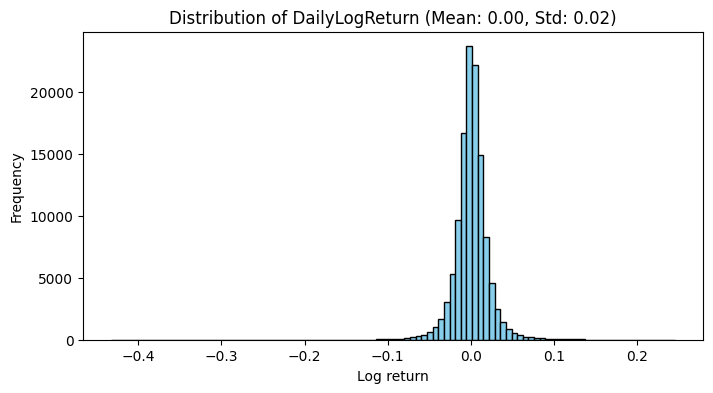

In [56]:
plt.figure(figsize=(8, 4))
column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

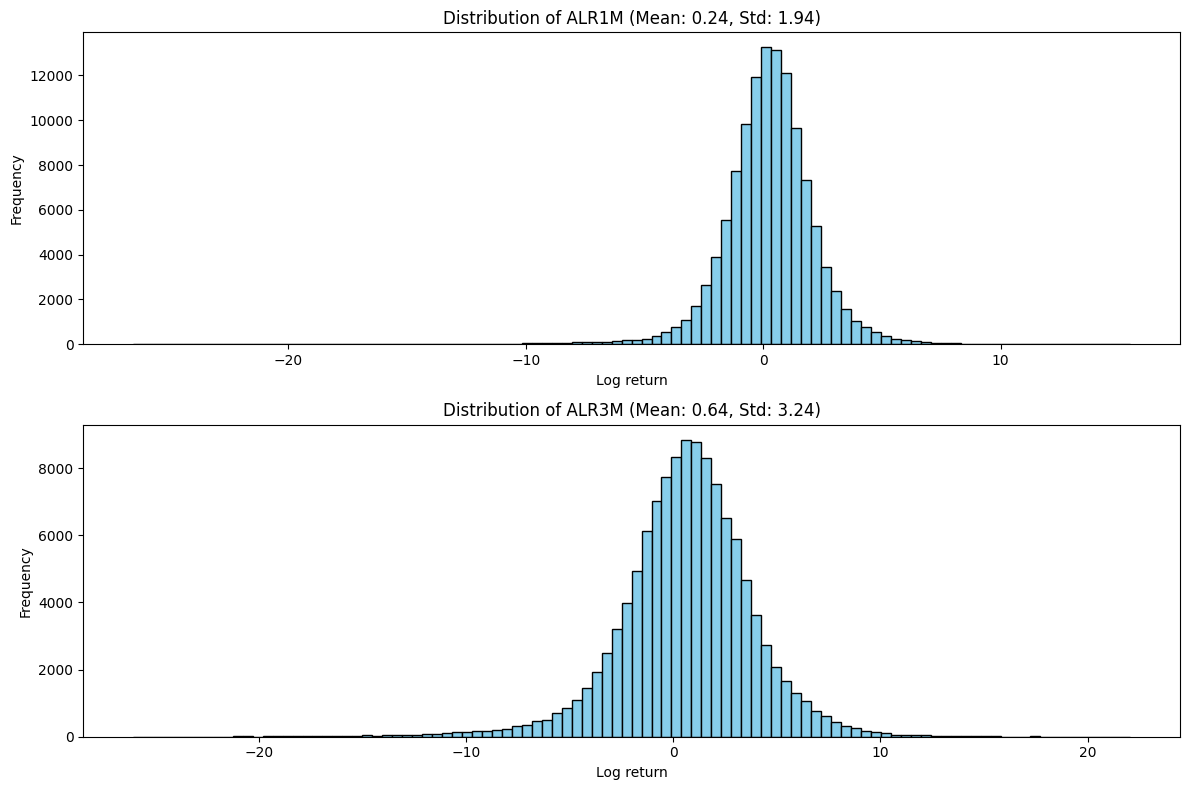

In [57]:
fig, axs = plt.subplots(2, figsize=(12, 8)) 
for idx, column in enumerate(["ALR1M", "ALR3M"]):
    ax = axs[idx]  
    ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
    ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
    ax.set_xlabel("Log return")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

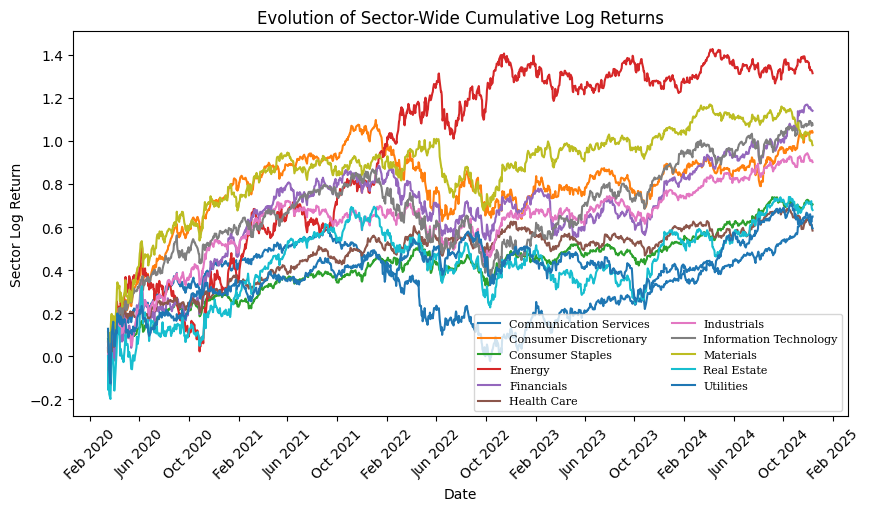

In [ ]:
sector_means = (
    values.reset_index()
    .groupby("Ticker")["DailyLogReturn"]  
    .mean()
    .reset_index()
    .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker")
    .groupby("Sector")["DailyLogReturn"]  
    .mean()
)

plt.figure(figsize=(10, 5))

for sector in sector_means.index:
    sector_values = (
        values.reset_index()
        .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker")
        .query(f"Sector == '{sector}'")
    )
    
    cumulative_returns = (
        sector_values.groupby("Date")["DailyLogReturn"].mean().cumsum()
    )
    
    plt.plot(cumulative_returns.index, cumulative_returns, label=sector)

plt.title("Evolution of Sector-Wide Cumulative Log Returns")
plt.xlabel("Date")
plt.gca().tick_params(axis="x", rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.ylabel("Sector Log Return")
plt.legend(ncol=2, loc="lower right", prop={"size": 8, "family": "serif"})
plt.show()

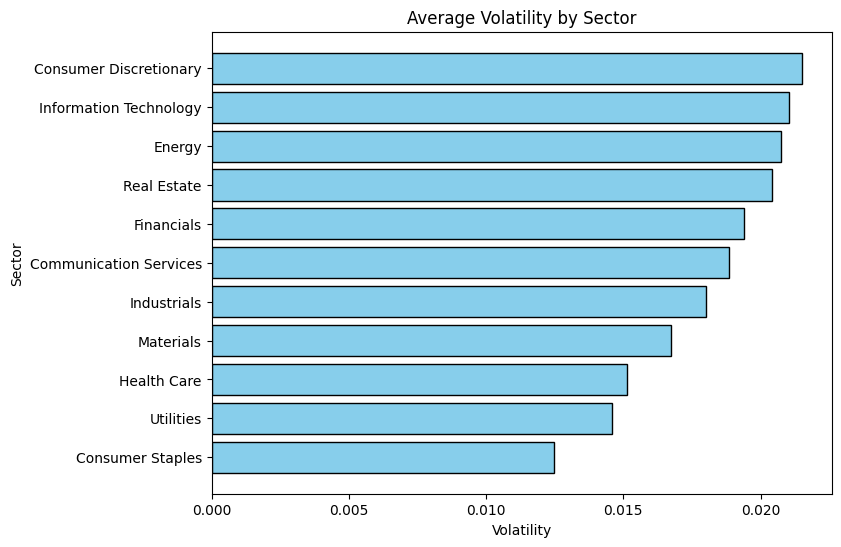

In [67]:
sector_volatility = (
    values.reset_index()
    .groupby("Ticker")["Volatility"]
    .mean()
    .reset_index()
    .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker")
    .groupby("Sector")["Volatility"]
    .mean()
    .sort_values(ascending=False)  # Sort sectors by volatility
)

plt.figure(figsize=(8, 6))  # Adjust figure size
plt.barh(sector_volatility.index, sector_volatility.values, color="skyblue", edgecolor="black")
plt.title("Average Volatility by Sector")
plt.xlabel("Volatility")
plt.ylabel("Sector")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest at the top
plt.show()

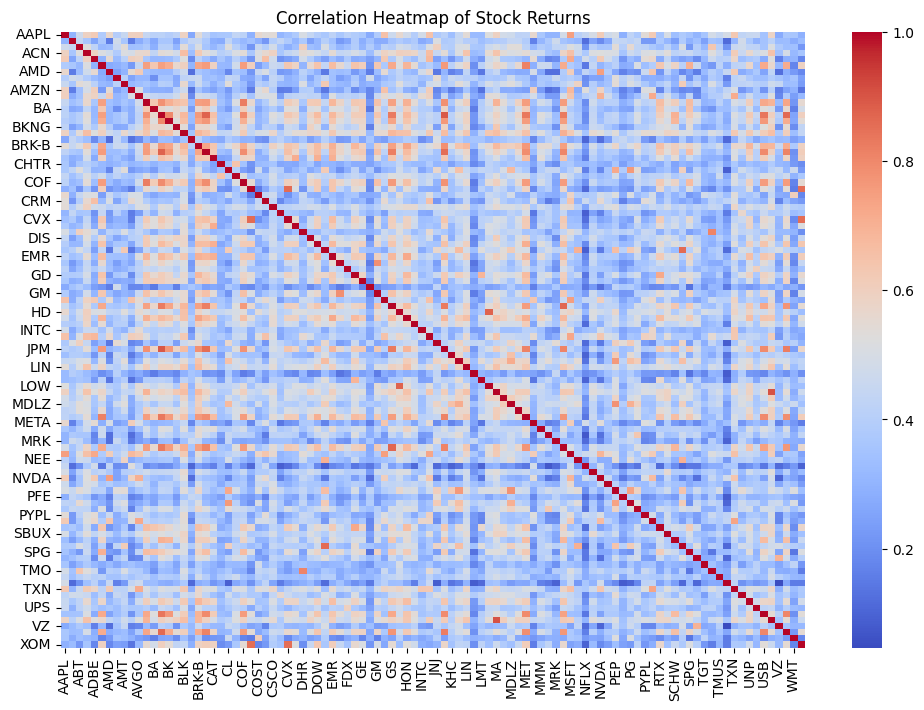

In [68]:
correlation_matrix = returns_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Stock Returns")
plt.show()

### 1.5. Neo4j Graph

In [71]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

try:
    print("Connected to Neo4j!")
except Exception as e:
    print(f"Connection failed: {e}")

Connected to Neo4j!
